# working on multi classification model

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

In [2]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 101),
        np.linspace(y_min, y_max, 101)
    )

    # Make features for prediction
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))
    ).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

        # Multi-class vs binary classification
        if len(torch.unique(y)) > 2:
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multi-class
        else:
            y_pred = torch.round(torch.sigmoid(y_logits))          # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolor="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


In [3]:
#Calculate accuracy -out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct=torch.eq(y_true, y_pred).sum().item()
    acc=(correct/len(y_pred)) * 100
    return acc

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary2(model, X, y):
    # 1. Define grid boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # 2. Create meshgrid (all possible points in the 2D space)
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 101),  # 101 points along x-axis
        np.linspace(y_min, y_max, 101)   # 101 points along y-axis
    )

    # 3. Flatten the grid → prepare for prediction
    grid_points = np.column_stack((xx.ravel(), yy.ravel()))

    # 4. Make predictions on the grid
    y_pred = model(grid_points)

    # 5. Reshape predictions back to grid shape
    y_pred = y_pred.reshape(xx.shape)

    # 6. Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolor="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


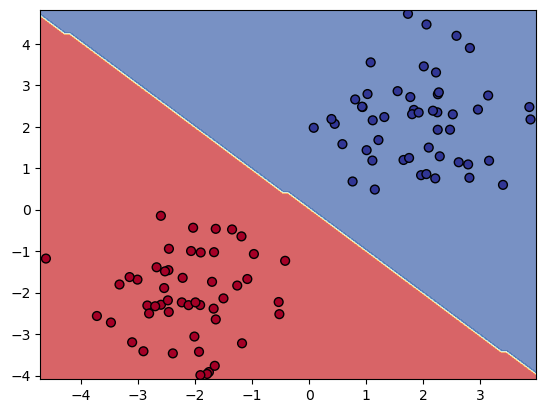

In [5]:
import numpy as np

# 1. Create simple dummy data
np.random.seed(42)
X_class0 = np.random.randn(50, 2) + np.array([-2, -2])  # cluster near (-2, -2)
X_class1 = np.random.randn(50, 2) + np.array([2, 2])    # cluster near (2, 2)

X = np.vstack((X_class0, X_class1))  # shape (100, 2)
y = np.array([0]*50 + [1]*50)        # labels

# 2. Define a simple dummy "model"
def dummy_model(X_input):
    # simple rule: x0 + x1 > 0 → class 1 else class 0
    return (X_input[:, 0] + X_input[:, 1] > 0).astype(int)

# 3. Use your plot_decision_boundary
plot_decision_boundary2(dummy_model, X, y)


### creatinng a toy multi class dataset

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
x_blob, y_blob = make_blobs(
    n_samples=1000,              
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,            
    random_state=RANDOM_SEED)

x_blob=torch.from_numpy(x_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train,x_blob_test,y_blob_train,y_blob_test=train_test_split(x_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=42)


<Axes: xlabel='None', ylabel='None'>

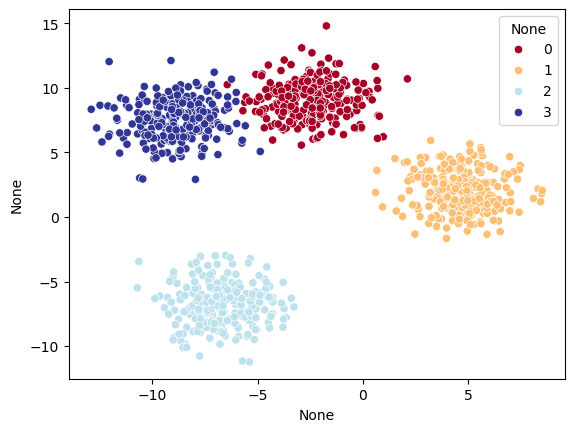

In [7]:
import seaborn as sns
sns.scatterplot(x=x_blob[:,0],y=x_blob[:,1],hue=y_blob,palette=plt.cm.RdYlBu)

In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# bulding a multi class classification model
class BlobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)  )
    def forward(self,x):
        return self.linear_layer_stack(x)

In [10]:
model_4=BlobModel(input_features=2,
                 output_features=4,
                 hidden_units=16).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [11]:
x_blob_train.shape,y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [12]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [13]:
#create loss functioon 
loss_fn=nn.CrossEntropyLoss()
#create an optimizer
optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [14]:
x_blob_train,x_blob_test,y_blob_train,y_blob_test=x_blob_train.to(device),x_blob_test.to(device),y_blob_train.to(device),y_blob_test.to(device)

In [15]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_blob_test)
y_logits[:10]

tensor([[ 0.3029, -0.4764, -0.3320, -0.5511],
        [ 0.4189, -2.3227,  0.4494, -0.4152],
        [ 0.8317, -2.8160, -0.7520, -1.6311],
        [-0.0213, -0.2855, -0.2763, -0.4492],
        [ 0.8113, -1.4447,  0.2106, -0.7982],
        [ 0.4945, -2.8533,  0.5624, -0.4501],
        [ 0.6424, -2.4850, -0.6963, -1.4232],
        [ 0.5604, -1.4237,  0.2151, -0.6435],
        [ 1.1161, -3.4783, -0.7298, -2.0060],
        [ 0.6355, -1.3979,  0.2045, -0.6847]], device='cuda:0')

### Getting prediction probabilities for a multi-class PyTorch model
In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.

Logits -> Pred probs -> Pred labels 

In [16]:
# convert our model's logit outputs to prediction probabilities
y_pred_probs=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.3029, -0.4764, -0.3320, -0.5511],
        [ 0.4189, -2.3227,  0.4494, -0.4152],
        [ 0.8317, -2.8160, -0.7520, -1.6311],
        [-0.0213, -0.2855, -0.2763, -0.4492],
        [ 0.8113, -1.4447,  0.2106, -0.7982]], device='cuda:0')
tensor([[0.4142, 0.1900, 0.2195, 0.1763],
        [0.3953, 0.0255, 0.4075, 0.1717],
        [0.7596, 0.0198, 0.1559, 0.0647],
        [0.3130, 0.2403, 0.2426, 0.2041],
        [0.5396, 0.0565, 0.2959, 0.1079]], device='cuda:0')


In [17]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [18]:
torch.max(y_pred_probs[0])

tensor(0.4142, device='cuda:0')

In [19]:
torch.argmax(y_pred_probs[0])

tensor(0, device='cuda:0')

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of itrations
epochs=100

# build training annd tesing loop
for epoch in range(epochs):
    ## training 
    model_4.train()

    #forward pass
    y_logits= model_4(x_blob_train).squeeze()
    y_preds= torch.softmax(y_logits,dim=1).argmax(dim=1)

    # calculate loss
    loss=loss_fn(y_logits,y_blob_train)
    acc=accuracy_fn(y_blob_train,y_preds)

    # optimizer zero gard
    optimizer.zero_grad()

    #loss backword
    loss.backward()

    #optimizer step
    optimizer.step()

    ###testing 
    model_4.eval()
    with torch.inference_mode():
        #forward pass
        test_logits=model_4(x_blob_test).squeeze()
        test_pred=y_preds= torch.softmax(test_logits,dim=1).argmax(dim=1)
        # calculate loss
        test_loss=loss_fn(test_logits,y_blob_test)
        test_acc=accuracy_fn(y_blob_test,test_pred)
    if epoch% 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.4f} | accuracy: {acc:.2f}% | test loss: {test_loss:.4f} | test accuracy {test_acc:.2f}%")

Epoch: 0 | loss: 1.4973 | accuracy: 25.50% | test loss: 0.8706 | test accuracy 73.50%
Epoch: 10 | loss: 0.2350 | accuracy: 98.25% | test loss: 0.1927 | test accuracy 99.00%
Epoch: 20 | loss: 0.1015 | accuracy: 98.88% | test loss: 0.0879 | test accuracy 99.00%
Epoch: 30 | loss: 0.0675 | accuracy: 99.00% | test loss: 0.0589 | test accuracy 99.00%
Epoch: 40 | loss: 0.0537 | accuracy: 99.00% | test loss: 0.0462 | test accuracy 99.00%
Epoch: 50 | loss: 0.0464 | accuracy: 99.00% | test loss: 0.0392 | test accuracy 99.00%
Epoch: 60 | loss: 0.0419 | accuracy: 99.00% | test loss: 0.0347 | test accuracy 99.50%
Epoch: 70 | loss: 0.0388 | accuracy: 99.00% | test loss: 0.0315 | test accuracy 99.50%
Epoch: 80 | loss: 0.0367 | accuracy: 99.00% | test loss: 0.0292 | test accuracy 99.50%
Epoch: 90 | loss: 0.0351 | accuracy: 99.00% | test loss: 0.0274 | test accuracy 99.50%


In [21]:
# make predictions
model_4.eval()
with torch.inference_mode():
     y_logits=model_4(x_blob_test)

#view the first 10 predictions     
y_logits[:10]

tensor([[-0.8949,  5.7518, -2.1364, -5.1732],
        [-0.8786, -5.8755, -1.2055,  5.2511],
        [-7.1536, -3.1970,  5.0541, -2.7582],
        [-1.0685,  4.2472, -1.4562, -3.4325],
        [ 5.0534, -0.7170, -4.1507, -2.8261],
        [-1.3792, -7.1982, -1.1877,  6.5496],
        [-6.2998, -2.5893,  4.3823, -2.9557],
        [ 4.7808, -1.9825, -3.7187, -1.3293],
        [-8.9363, -4.5197,  6.2711, -2.1877],
        [ 4.9158, -1.7116, -3.7282, -1.7748]], device='cuda:0')

In [24]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[1.2961e-03, 9.9831e-01, 3.7449e-04, 1.7971e-05],
        [2.1689e-03, 1.4661e-05, 1.5642e-03, 9.9625e-01],
        [4.9885e-06, 2.6080e-04, 9.9933e-01, 4.0444e-04],
        [4.8715e-03, 9.9136e-01, 3.3059e-03, 4.5812e-04],
        [9.9642e-01, 3.1072e-03, 1.0026e-04, 3.7705e-04],
        [3.5992e-04, 1.0692e-06, 4.3589e-04, 9.9920e-01],
        [2.2916e-05, 9.3662e-04, 9.9839e-01, 6.4929e-04],
        [9.9643e-01, 1.1512e-03, 2.0283e-04, 2.2123e-03],
        [2.4857e-07, 2.0585e-05, 9.9977e-01, 2.1200e-04],
        [9.9727e-01, 1.3200e-03, 1.7570e-04, 1.2391e-03]], device='cuda:0')

In [26]:
y_pred_probs[0]

tensor([1.2961e-03, 9.9831e-01, 3.7449e-04, 1.7971e-05], device='cuda:0')

In [27]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [29]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [30]:
y_preds=torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

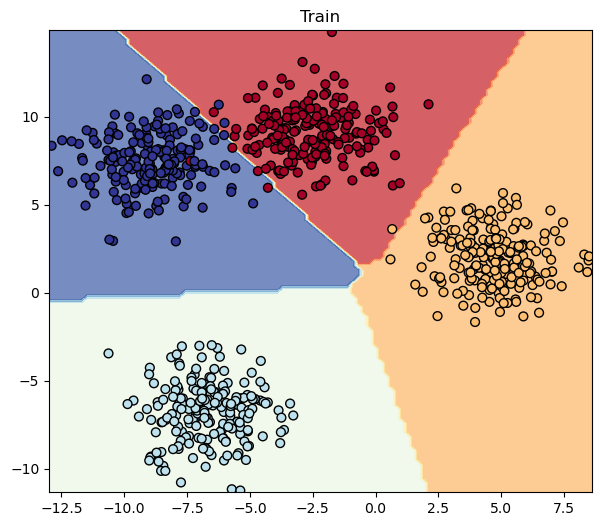

In [37]:
plt.figure(figsize=(7, 6))
plt.title("Train")
plot_decision_boundary (model_4, x_blob_train, y_blob_train)

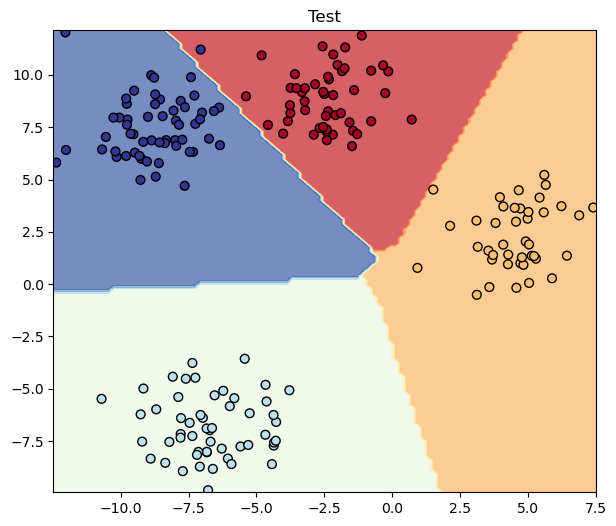

In [38]:
plt.figure(figsize=(7, 6))
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test) 

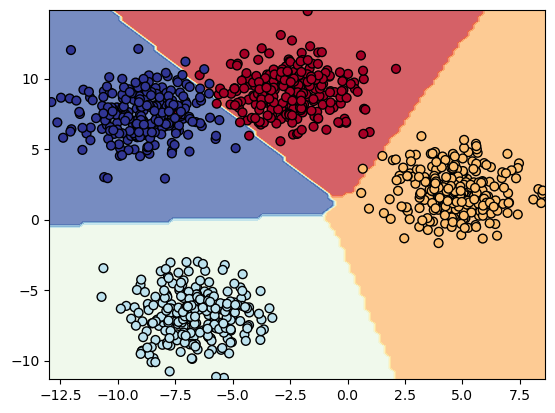

In [39]:
plot_decision_boundary(model_4,x_blob,y_blob)

In [2]:
!jupyter nbconvert --to webpdf pytorch_multi_classification.ipynb

[NbConvertApp] Converting notebook pytorch_multi_classification.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 512342 bytes to pytorch_multi_classification.pdf
